# Make Recommendation

In [1]:

from sqlalchemy.orm import sessionmaker
from models import connect_db, PointsOfInterest, ArchitecturalStyles, Architects,POICategories
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance
import geocoder
import os
from dotenv import load_dotenv, find_dotenv
import time
import seaborn as sns
import numpy as np
DEBUG=0

In [2]:
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, Imputer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder
)

In [3]:
db=connect_db() #establish connection / creates database on first run
Session = sessionmaker(bind=db)
session = Session()

In [4]:
def make_simple_poi(org_type):
    if org_type == 'Plaque':
        return org_type
    elif org_type == 'Monument':
        return 'Art'
    else:
        return 'Building'


In [5]:
def clean_build_year(year):
    if year == None or len(year) < 4:
        return ''
    strip_words = ['unknown', 'circa ', 'abt ', 'about']
    for word in strip_words:
        year=year.replace(word, '')
    return year[0:4]

In [109]:

# sql='''SELECT poi.*, styl.style, arct.architect_name, pcat.category
# FROM points_of_interest poi
# LEFT JOIN architectural_styles styl on (styl.poi_id = poi.poi_id)
# LEFT JOIN architects arct on (arct.poi_id = poi.poi_id)
# LEFT JOIN poi_categories pcat on (pcat.poi_id = poi.poi_id)
# order by poi.poi_id
# '''

sql='''SELECT poi.*, styl.style, pcat.category
FROM points_of_interest poi
LEFT JOIN architectural_styles styl on (styl.poi_id = poi.poi_id)
LEFT JOIN poi_categories pcat on (pcat.poi_id = poi.poi_id)
order by poi.poi_id
'''
# pd.DataFrame(db.execute(sql))
# #res.first()
df = pd.read_sql_query(sql, db)
df.head()

,poi_id,name,build_year,demolished_year,address,latitude,longitude,external_url,image_url,heritage_status,current_use,poi_type,source,details,style,category
0,2,22 Chestnut Park,1905,None,22 Chestnut Park Rosedale Toronto,43.679380,-79.388100,http://www.acotoronto.ca/show_building.php?Bui...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,South Rosedale Heritage Conservation District,Residential,Detached house,http://www.acotoronto.ca/,"First Occupant: Falconbridge, John D.\r\r\n\r\...",American colonial,None
1,8,43 Cross Street,unknown,None,"43 Cross Street Weston York, ON",43.705088,-79.525501,http://www.acotoronto.ca/show_building.php?Bui...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,Weston Heritage Conservation District,Residential,Detached house,http://www.acotoronto.ca/,None,Arts and Crafts,None
2,9,Alexander Gemmell House,1889,None,181 Ellis Avenue Swansea Toronto,43.642920,-79.470770,http://www.acotoronto.ca/show_building.php?Bui...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,Heritage property,Residential,Detached house,http://www.acotoronto.ca/,None,Arts and Crafts,None
3,13,15-17 Gifford Street,unknown,None,15-17 Gifford Street Cabbagetown Toronto,43.663300,-79.363120,http://www.acotoronto.ca/show_building.php?Bui...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,Cabbagetown South Heritage Conservation District,Residential,Semi-detached house,http://www.acotoronto.ca/,None,Arts and Crafts,None
4,14,18 Gifford Street,unknown,None,18 Gifford Street Cabbagetown Toronto,43.663150,-79.363600,http://www.acotoronto.ca/show_building.php?Bui...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,Cabbagetown South Heritage Conservation District,Residential,Detached house,http://www.acotoronto.ca/,None,Arts and Crafts,None


In [110]:

df['cleaned_year']=df['build_year'].apply(lambda x: clean_build_year(x))


In [111]:

df['cleaned_year']=pd.to_numeric(df['cleaned_year'],errors='coerce',downcast='integer')


In [112]:
df['build_decade']= df['cleaned_year'].apply(lambda x: x//10*10 )


In [113]:
df['poi_type_simple'] = df['poi_type'].apply(lambda x: make_simple_poi(x))

In [114]:
poi_mapper = DataFrameMapper([
   #('Date',None),
    # drop block and address
   # (['poi_id'], None),
    ('build_decade',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
     ('category',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
     #('architect_name',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
     ('style',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
     ('poi_type_simple',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
    # ('current_use',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
  #  (['latitude'],None),
  #  (['longitude'],None)
], df_out=True)

In [115]:

poi_mapper.fit(df)
df_features= poi_mapper.transform(df)
df_features.head()
# drop build_decade_0.0
# keywords

,build_decade_1790.0,build_decade_1810.0,build_decade_1820.0,build_decade_1830.0,build_decade_1840.0,build_decade_1850.0,build_decade_1860.0,build_decade_1870.0,build_decade_1880.0,build_decade_1890.0,...,style_Romanesque revival,style_Sculptural,style_Second empire,style_Shingle style,style_Spanish colonial,style_Toronto Bay and Gable,style_Workers Cottage,poi_type_simple_Art,poi_type_simple_Building,poi_type_simple_Plaque
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [116]:
df_features.shape

(4384, 105)

In [266]:
# USER PROFILE 1 - interested in People (plaques), Entrepreneurs (32) Medicine (44), Science and Technology (52), Women (56), Sports(53) and modern buildings
user_prefs = np.zeros(105)
for i in [32, 52, 44, 56,53, 67,70,75,77, 79, 80, 83, 89, 104]:
    user_prefs[i] = 1
#user_prefs.shape

In [275]:
# USER PROFILE 2 -- interested in People (plaques 104) Explorers (33), Pioneers (46), Cemeteries (25), First Nations(35)
# and early buildings (0-9)
user_prefs = np.zeros(105)
for i in [0,1,2,3,4,5,6,7,8,9,25, 33,35, 46,104]:
    user_prefs[i] = 1

In [283]:
# USER PROFILE 3 -- interested in Art ()
user_prefs = np.zeros(105)
for i in [102]:
    user_prefs[i] = 1

In [284]:
# cols = df_features.columns
# ct = 0
# for col in cols:
#     print(ct,col)
#     ct +=1
# #cols[104]

In [285]:
df_user=pd.DataFrame(user_prefs).T#, columns=df_features.columns)
df_user.columns = df_features.columns
#df_user=pd.DataFrame.from_records(user_prefs,)
df_user.head()

,build_decade_1790.0,build_decade_1810.0,build_decade_1820.0,build_decade_1830.0,build_decade_1840.0,build_decade_1850.0,build_decade_1860.0,build_decade_1870.0,build_decade_1880.0,build_decade_1890.0,...,style_Romanesque revival,style_Sculptural,style_Second empire,style_Shingle style,style_Spanish colonial,style_Toronto Bay and Gable,style_Workers Cottage,poi_type_simple_Art,poi_type_simple_Building,poi_type_simple_Plaque
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [286]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(df_features,df_user)

In [287]:
cosine_sim[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

In [288]:
user_matches = pd.DataFrame(cosine_sim, columns=['user_match'])
user_matches.sort_values('user_match', ascending=False, inplace=True)


In [289]:
#user_matches.iloc[0:20,:]
df['sim_rating'] = 0
for ix,row in user_matches.iloc[0:20,:].iterrows():
    # now find matches close to target of interest
    print(df.iloc[ix,1])
    df.loc[ix,'sim_rating'] = row.user_match
   # print(ix)
df.sort_values('sim_rating', inplace=True, ascending=False)

40-54 Phoebe Street
25-27 Howard Street
66 Charles Street East
44-46 Russell Street
29 Jarvis Street
Trinity-St. Paul's United Church
Forest Hill United Church
Canada vs Russia
Edward Hanlan 1855-1908
Hockey Hall of Fame
Leafs Kings 1993
Bill Barilko
All Star Game
Maple Leaf Gardens
Cliffside Golf Course 1931-1950
First Grey Cup Game
"Ned" Hanlan 1855-1908
Marilyn Bell
The Resting Place of Pioneers
20-22 Nasmith Avenue


In [290]:
#print(df[df['name']=="The Royal York Hotel"]['external_url'])

In [291]:
# profile 1: architecture lover from 18000s
# profile 2: modern architecture
# profile 3: history buff interested in people and sports
# profile 4: art lover

### Distance Method 2: scipy

In [292]:
from scipy import spatial
d1 = [3,5,5,3,3,2]
d2 = [1,1,3,1,3,2]
#weight_of_importance = [0.05,0.05,0.1,0.1,0.4,0.3] #,0841
#weight_of_importance = [0.1,0.1,0.2,0.2,0.1,0.3] #.1062
weight_of_importance = [0.3,0.3,0.1,0.1,0.1,0.1] #.164 greater distance

result = spatial.distance.cosine(d1, d2, weight_of_importance)
print(result)

0.16329848310579587


In [293]:
np_features = df_features.as_matrix()
type(np_features)
len(np_features)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


4384

In [294]:
site_prefs=[]
for i in range(0,len(np_features)):
    np_features[i,:]
    result = spatial.distance.cosine(np_features[i,:], user_prefs)#, weight_of_importance)
    res_dict = {'ix': i, 'dist': result}
    site_prefs.append(res_dict)
df_site_prefs = pd.DataFrame(site_prefs)

In [295]:
# site_prefs.sort()
# site_prefs[0:20]
df_site_prefs.sort_values('dist', inplace=True)
df_site_prefs.head()

,dist,ix
2653,0.5,2653
201,0.5,201
990,0.5,990
234,0.5,234
403,0.5,403


In [296]:
#user_matches.iloc[0:20,:]
for ix,row in df_site_prefs.iloc[0:20,:].iterrows():
    # now find matches close to target of interest
    print(df.iloc[ix,1])
   # print(ix)

8 Miles Road
Crosse & Blackwell Building
Knox Presbyterian Church
170 Strathearn Road
Ryerson University; Library Building
83-85 Walmer Road
Cloverhill Apartments
Ontario Lakeshore Asylum Cemetery
Jean-Baptiste Rousseaux 1758-1812
The Taylor Cemetery
Christie's Methodist Cemetery
The Cummer Family
Exhibition Place; Shrine Peace Memorial
Mount Hope Cemetery 1898
Mount Pleasant Cemetery
Mount Pleasant Cemetery
The Old Garrison Burying Ground 1794-1863
Military Burial Ground
The Beginnings of French Toronto
Joseph Shepard


### Test from a point

In [297]:
# spadina/college
# starting_lat =43.657847
# starting_long= -79.399801
# king/simco
starting_lat =43.647273
starting_long=-79.386560

walk_duration = 1 # in hours
num_points = 12
max_distance = 1000 # meters
num_pois_visit = 20

In [298]:

#geopy.distance.geodesic((54.277828,-0.410680), (43.657847,-79.399801)).meters

In [299]:
def find_points_in_area(df, lat, long, num_points, max_distance):
    
    avail_points = []
    found_points =0
    prev_coord = (0,0) # sometimes have two points at same lat/long -- don't count as an extra stop
    
    for ix, row in df.iterrows():

        curr_pt = geopy.distance.geodesic((row['latitude'], row['longitude']), (lat, long)).meters
       # print(curr_pt)
        
        if curr_pt<= max_distance:
            print(row['latitude'], row['longitude'], curr_pt)
            my_dict={}
            my_dict =row.to_dict()
            my_dict['dist_start'] = curr_pt
            avail_points.append(my_dict)
            if (row['latitude'], row['longitude']) !=prev_coord:
                found_points +=1
            prev_coord = (row['latitude'], row['longitude'])
            if found_points > num_points:
                break
    df_2 = pd.DataFrame(avail_points)
    return df_2

In [300]:
df_filtered = find_points_in_area(df, starting_lat, starting_long, num_points, max_distance)

43.65538 -79.38839 912.7505525143358
43.646795 -79.377299 749.063931487287
43.64387 -79.37958 678.3093416988032
43.64814 -79.38044 503.06574284246784
43.64396 -79.37889 720.0304621828755
43.64622 -79.39646 807.2600945791702
43.6537678 -79.3783212 981.0721088120089
43.64978 -79.38244 433.67149006107866
43.64632 -79.3927 506.5676011886542
43.64859 -79.38909 251.1479336959561
43.6491 -79.38 566.8439615219222
43.64515 -79.39847 989.4407205287612
43.6486892700195 -79.3854370117188 181.5744527018148


In [301]:
df_filtered

,address,build_decade,build_year,category,cleaned_year,current_use,demolished_year,details,dist_start,external_url,...,image_url,latitude,longitude,name,poi_id,poi_type,poi_type_simple,sim_rating,source,style
0,University Avenue Financial District Toronto,1930.0,1934,None,1934.0,None,None,None,912.750553,http://www.acotoronto.ca/show_building.php?Bui...,...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,43.655380,-79.388390,Adam Beck Memorial,317,Monument,Art,0.5,http://www.acotoronto.ca/,Art deco
1,None,NaN,None,Sports,NaN,None,None,"Outside the Hockey Hall of Fame, on the northw...",749.063931,http://torontoplaques.com/Pages/Hockey_Hall_of...,...,None,43.646795,-79.377299,Hockey Hall of Fame,8388,Plaque,Plaque,0.0,http://torontoplaques.com,None
2,None,NaN,None,Sports,NaN,None,None,This Historic Sites and Monuments Board of Can...,678.309342,http://torontoplaques.com/Pages/Toronto_Maple_...,...,None,43.643870,-79.379580,Toronto Maple Leafs,8394,Plaque,Plaque,0.0,http://torontoplaques.com,None
3,234 Bay Street Financial District Toronto,1930.0,1937,None,1937.0,Cultural,None,This building was constructed to house the Tor...,503.065743,http://www.acotoronto.ca/show_building.php?Bui...,...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,43.648140,-79.380440,Design Exchange,218,Mid-rise,Building,0.0,http://www.acotoronto.ca/,Art deco
4,50 Bay Street Harbourfront Toronto,1990.0,1999,None,1999.0,Sports,None,This bulding incorporates the Art Deco facade ...,720.030462,http://www.acotoronto.ca/show_building.php?Bui...,...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,43.643960,-79.378890,Scotiabank Arena,217,High-rise,Building,0.0,http://www.acotoronto.ca/,Art deco
5,385 Adelaide Street West Fashion District Toronto,1940.0,1944,None,1944.0,Commercial,None,None,807.260095,http://www.acotoronto.ca/show_building.php?Bui...,...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,43.646220,-79.396460,Lorne Building,208,Low-rise,Building,0.0,http://www.acotoronto.ca/,Art deco
6,30 Bond Street Downtown East Toronto,1930.0,1937,None,1937.0,Health care,None,None,981.072109,http://www.acotoronto.ca/show_building.php?Bui...,...,http://www.acotoronto.ca/tobuilt_bk/php/buildi...,43.653768,-79.378321,St. Michael's Hospital,238,Mid-rise,Building,0.0,http://www.acotoronto.ca/,Art deco
7,100 Adelaide Street West Financial District To...,1920.0,1928,None,1928.0,Office,None,None,433.671490,http://www.acotoronto.ca/show_building.php?Bui...,...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,43.649780,-79.382440,Concourse Building,207,High-rise,Building,0.0,http://www.acotoronto.ca/,Art deco
8,388 King Street West Entertainment District To...,1940.0,1941,None,1941.0,Commercial,None,This building was altered in 1986.,506.567601,http://www.acotoronto.ca/show_building.php?Bui...,...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,43.646320,-79.392700,388 King Street West,273,Low-rise,Building,0.0,http://www.acotoronto.ca/,Art deco
9,26 Duncan Street Entertainment District Toronto,1940.0,1948,None,1948.0,Commercial,None,None,251.147934,http://www.acotoronto.ca/show_building.php?Bui...,...,http://www.acotoronto.ca/tobuilt_bk/php/Buildi...,43.648590,-79.389090,Cundari Building,258,Mid-rise,Building,0.0,http://www.acotoronto.ca/,Art deco


In [302]:
#initialize map with a default lat and long
import folium
map_clusters = folium.Map(location=[43.67146, -79.37515], zoom_start=11)
folium.CircleMarker(
    [starting_lat, starting_long],
    radius=5,
    color='red',
     fill=True,
       fill_color='#3186cc',
       fill_opacity=0.7).add_to(map_clusters)



# loop through dataframe
for lat, lng, name, address in zip(df_filtered['latitude'], df_filtered['longitude'],  df_filtered['name'],df_filtered['address']):
   label = '{} {}'.format(name, address)
   label = folium.Popup(label, parse_html=True)
   folium.CircleMarker(
       [lat, lng],
       radius=5,
       popup=label,
       color='blue',
       fill=True,
       fill_color='#3186cc',
       fill_opacity=0.7).add_to(map_clusters)

map_clusters

# GENETIC ALGORITHM TO PLOT POINTS
* borrowed and slightly adapted from https://github.com/ZWMiller/PythonProjects/blob/master/genetic_algorithms/evolutionary_algorithm_traveling_salesman.ipynb

In [303]:
# TODO: cluster points

In [304]:
df_filtered.iloc

In [305]:
# create dictionary of stops with lat/long coords
print(f'starting point ({starting_lat}, {starting_long})')
walk_stops = {}
walk_stops[0] = (starting_lat, starting_long)
for ix,row in df_filtered.iterrows():
    #walk_stops[ix+1] = (row['latitude'], row['longitude'])
    walk_stops[row['poi_id']] = (row['latitude'], row['longitude'])
walk_stops

starting point (43.647273, -79.38656)


{0: (43.647273, -79.38656),
 317: (43.65538, -79.38839),
 8388: (43.646795, -79.377299),
 8394: (43.64387, -79.37958),
 218: (43.64814, -79.38044),
 217: (43.64396, -79.37889),
 208: (43.64622, -79.39646),
 238: (43.6537678, -79.3783212),
 207: (43.64978, -79.38244),
 273: (43.64632, -79.3927),
 258: (43.64859, -79.38909),
 272: (43.6491, -79.38),
 274: (43.64515, -79.39847),
 285: (43.6486892700195, -79.3854370117188)}

In [306]:

from copy import copy
# def create_guess(walk_stops):
#     """
#     Creates a possible path between all cities, returning to the original.
#     Input: List of City IDs
#     """
#     guess = copy(walk_stops)
#     np.random.shuffle(guess)
#     guess.append(guess[0])
#     return list(guess)
def create_guess(walk_stops):
    """
    Creates a possible path between all cities, returning to the original.
    Point 0 is our starting point and must stay as our starting point
    Input: List of City IDs
    """
    guess = copy(walk_stops)
   # print(f"before shuffle {guess}")
    start = guess.pop(0)# save our starting point and remove from dict
    np.random.shuffle(guess)
   # print(f"after shuffle {guess}")
   # guess[0] = start
    guess.insert(0,start)
    #guess.append(guess[0])
    return list(guess)

print(create_guess(list(walk_stops.keys())))


[0, 208, 317, 238, 218, 258, 274, 217, 8388, 8394, 285, 207, 273, 272]


In [307]:

def create_generation(points, population=100):
    """
    Makes a list of guessed point orders given a list of point IDs.
    Input:
    points: list of point ids
    population: how many guesses to make
    """
    generation = [create_guess(points) for _ in range(population)]
    return generation

# test_generation = create_generation(list(walk_stops.keys()), population=10)
# for gen in test_generation:
#     print(gen)

In [308]:
def travel_time_between_points(point_1, point_2):
    '''
    pass in coords for 2 points
    calculate distance between them in meters and then estimate walking time
    '''
    # typical walkign speed is 1.4m/sec
    speed = 1.4
    #find dist between 2 points
    dist = geopy.distance.geodesic(point_1, point_2).meters
    # return guess speed in seconds
    return dist/speed

In [309]:
def fitness_score(guess):
    """
    Loops through the points in the guesses order and calculates
    how much distance the path would take to complete a loop.
    Lower is better.
    """
    score = 0
    for ix, point_id in enumerate(guess[:-1]):
        score += travel_time_between_points(walk_stops[point_id], walk_stops[guess[ix+1]])
    return score

def check_fitness(guesses):
    """
    Goes through every guess and calculates the fitness score. 
    Returns a list of tuples: (guess, fitness_score)
    """
    fitness_indicator = []
    for guess in guesses:
        fitness_indicator.append((guess, fitness_score(guess)))
    return fitness_indicator

#print(check_fitness(test_generation))

In [310]:
def get_breeders_from_generation(guesses, take_best_N=10, take_random_N=5, verbose=False, mutation_rate=0.1):
    """
    This sets up the breeding group for the next generation. You have
    to be very careful how many breeders you take, otherwise your
    population can explode. These two, plus the "number of children per couple"
    in the make_children function must be tuned to avoid exponential growth or decline!
    """
    # First, get the top guesses from last time
    fit_scores = check_fitness(guesses)
    sorted_guesses = sorted(fit_scores, key=lambda x: x[1]) # sorts so lowest is first, which we want
    new_generation = [x[0] for x in sorted_guesses[:take_best_N]] # takes top 5
    best_guess = new_generation[0] # best guess is the best score
    
    if verbose:
        # If we want to see what the best current guess is!
        print(best_guess)
    
    # Second, get some random ones for genetic diversity
    for _ in range(take_random_N):
        ix = np.random.randint(len(guesses))
        new_generation.append(guesses[ix])
        
    # No mutations here since the order really matters.
    # If we wanted to, we could add a "swapping" mutation,
    # but in practice it doesn't seem to be necessary
    
    np.random.shuffle(new_generation)
    return new_generation, best_guess

def make_child(parent1, parent2):
    """ 
    Take some values from parent 1 and hold them in place, then merge in values
    from parent2, filling in from left to right with cities that aren't already in 
    the child. 
    """
    list_of_ids_for_parent1 = list(np.random.choice(parent1, replace=False, size=len(parent1)//2))
   # print(list_of_ids_for_parent1)
    child = [-99 for _ in parent1] # fill with placeholders so now all -99 values can be replaced with genes from parent 2
    
    for ix in range(0, len(list_of_ids_for_parent1)):
        child[ix] = parent1[ix]

    for ix, gene in enumerate(child):
 
        if gene == -99:
            for gene2 in parent2:
                if gene2 not in child:
                    child[ix] = gene2
                    break
    #child[-1] = child[0]
    return child

def make_children(old_generation, children_per_couple=1):
    """
    Pairs parents together, and makes children for each pair. 
    If there are an odd number of parent possibilities, one 
    will be left out. 
    
    Pairing happens by pairing the first and last entries. 
    Then the second and second from last, and so on.
    """
  #  print(old_generation)
    mid_point = len(old_generation)//2
#    print(mid_point)
    next_generation = [] 
    
    for ix, parent in enumerate(old_generation[:mid_point]):
        for _ in range(children_per_couple):
            next_generation.append(make_child(parent, old_generation[-ix-1]))
   # print(next_generation)
    return next_generation

In [311]:
# make_child([1,2,3,3,7,5,4],[1,6,7,8,5,4,3])

[1, 2, 3, 6, 7, 8, 5]

In [312]:
# current_generation = create_generation(list(walk_stops.keys()),population=500)
# for gen in current_generation:
#     print(gen)
# # print_every_n_generations = 5

# for i in range(100):
#     if not i % print_every_n_generations:
#         print("Generation %i: "%i, end='')
#         print(len(current_generation))
#         is_verbose = True
#     else:
#         is_verbose = False
#     breeders, best_guess = get_breeders_from_generation(current_generation, 
#                                                         take_best_N=250, take_random_N=100, 
#                                                         verbose=is_verbose)
#     current_generation = make_children(breeders, children_per_couple=3)


In [313]:
def evolve_to_solve(current_generation, max_generations, take_best_N, take_random_N,
                    mutation_rate, children_per_couple, print_every_n_generations, verbose=False):
    """
    Takes in a generation of guesses then evolves them over time using our breeding rules.
    Continue this for "max_generations" times.
    Inputs:
    current_generation: The first generation of guesses
    max_generations: how many generations to complete
    take_best_N: how many of the top performers get selected to breed
    take_random_N: how many random guesses get brought in to keep genetic diversity
    mutation_rate: How often to mutate (currently unused)
    children_per_couple: how many children per breeding pair
    print_every_n_geneartions: how often to print in verbose mode
    verbose: Show printouts of progress
    Returns:
    fitness_tracking: a list of the fitness score at each generations
    best_guess: the best_guess at the end of evolution
    """
    fitness_tracking = []
    for i in range(max_generations):
        if verbose and not i % print_every_n_generations and i > 0:
            print("Generation %i: "%i, end='')
            print(len(current_generation))
            print("Current Best Score: ", fitness_tracking[-1])
            is_verbose = True
        else:
            is_verbose = False
        breeders, best_guess = get_breeders_from_generation(current_generation, 
                                                            take_best_N=take_best_N, take_random_N=take_random_N, 
                                                            verbose=is_verbose, mutation_rate=mutation_rate)
        fitness_tracking.append(fitness_score(best_guess))
        current_generation = make_children(breeders, children_per_couple=children_per_couple)
    
    return fitness_tracking, best_guess

current_generation = create_generation(list(walk_stops.keys()),population=500)
# for gen in current_generation:
#     print(gen)

In [314]:
# take_best_N=250, take_random_N=100, 
#fitness_tracking, best_guess = evolve_to_solve(current_generation, 100, 150, 70, 0.5, 3, 5, verbose=True)
fitness_tracking, best_guess = evolve_to_solve(current_generation, 100, 150, 70, 0.5, 3, 5, verbose=True)

Generation 1: 330
Current Best Score:  5056.641433498096
[0, 273, 208, 274, 258, 218, 217, 285, 272, 207, 8388, 8394, 238, 317]
Generation 2: 330
Current Best Score:  5198.0368606848315
[0, 218, 207, 238, 317, 208, 274, 273, 217, 8394, 8388, 272, 285, 258]
Generation 3: 330
Current Best Score:  4765.366194152273
[0, 285, 8388, 218, 207, 272, 258, 208, 274, 273, 317, 238, 8394, 217]
Generation 4: 330
Current Best Score:  4819.601430591619
[0, 285, 8388, 218, 207, 272, 258, 208, 274, 273, 8394, 217, 238, 317]
Generation 5: 330
Current Best Score:  4829.820344786996
[0, 273, 208, 274, 258, 218, 217, 8394, 8388, 285, 207, 272, 317, 238]
Generation 6: 330
Current Best Score:  4603.097693908985
[0, 273, 208, 274, 258, 218, 217, 8394, 8388, 207, 238, 285, 272, 317]
Generation 7: 330
Current Best Score:  4837.582638726382
[0, 273, 208, 274, 258, 218, 217, 8394, 8388, 285, 207, 272, 238, 317]
Generation 8: 330
Current Best Score:  4291.609370236529
[0, 273, 208, 274, 258, 218, 217, 8394, 8388, 

[0, 285, 8388, 218, 207, 272, 258, 273, 208, 274, 217, 8394, 238, 317]
Generation 66: 330
Current Best Score:  4873.544879220393
[0, 285, 8388, 218, 207, 272, 258, 273, 208, 274, 217, 8394, 238, 317]
Generation 67: 330
Current Best Score:  4873.544879220393
[0, 285, 8388, 218, 207, 272, 258, 273, 208, 274, 217, 8394, 238, 317]
Generation 68: 330
Current Best Score:  4873.544879220393
[0, 285, 8388, 218, 207, 272, 258, 273, 208, 274, 217, 8394, 238, 317]
Generation 69: 330
Current Best Score:  4873.544879220393
[0, 285, 8388, 218, 207, 272, 258, 273, 208, 274, 217, 8394, 238, 317]
Generation 70: 330
Current Best Score:  4873.544879220393
[0, 285, 8388, 218, 207, 272, 258, 273, 208, 274, 217, 8394, 238, 317]
Generation 71: 330
Current Best Score:  4873.544879220393
[0, 285, 8388, 218, 207, 272, 258, 273, 208, 274, 217, 8394, 238, 317]
Generation 72: 330
Current Best Score:  4873.544879220393
[0, 285, 8388, 218, 207, 272, 258, 273, 208, 274, 217, 8394, 238, 317]
Generation 73: 330
Current

In [232]:
def plot_guess(city_coordinates, guess, guess_in_title=True):
    """
    Takes the coordinates of the cities and the guessed path and
    makes a plot connecting the cities in the guessed order
    Input:
    city_coordinate: dictionary of city id, (x,y)
    guess: list of ids in order
    """
    plot_cities(city_coordinates, guess=guess)
    for ix, current_city in enumerate(guess[:-1]):
        x = [city_coordinates[guess[ix]][0],city_coordinates[guess[ix+1]][0]]
        y = [city_coordinates[guess[ix]][1],city_coordinates[guess[ix+1]][1]]
        plt.plot(x,y,'c--',lw=1)
    plt.scatter(city_coordinates[guess[0]][0],city_coordinates[guess[0]][1], marker='x', c='b')   
    if guess_in_title:
        plt.title("Current Guess: [%s]"%(','.join([str(x) for x in guess])))
    else:
        print("Current Guess: [%s]"%(','.join([str(x) for x in guess])))
    


In [233]:
# def plot_cities(city_coordinates, annotate=True, guess=None):
#     """
#     Makes a plot of all cities.
#     Input: city_coordinates; dictionary of all cities and their coordinates in (x,y) format
#     """
#     names = []
#     x = []
#     y = []
#     plt.figure(dpi=250, figsize=(20,20))
#     for ix, coord in city_coordinates.items():
#         names.append(ix)
#         x.append(coord[0])
#         y.append(coord[1])
#         if annotate:
#             if guess:
#                 plt.annotate(guess[ix], xy=(coord[0], coord[1]), xytext=(20, -20),
#                             textcoords='offset points', ha='right', va='bottom',
#                             bbox=dict(boxstyle='round,pad=0.5', fc='w', alpha=0.5),
#                             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
#             else:
#                 plt.annotate(ix, xy=(coord[0], coord[1]), xytext=(20, -20),
#                             textcoords='offset points', ha='right', va='bottom',
#                             bbox=dict(boxstyle='round,pad=0.5', fc='w', alpha=0.5),
#                             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
#     plt.scatter(x,y,c='r',marker='o')

In [315]:
def plot_cities(city_coordinates, annotate=True, guess=None):
    """
    Makes a plot of all cities.
    Input: city_coordinates; dictionary of all cities and their coordinates in (x,y) format
    """
    names = []
    x = []
    y = []
    plt.figure(dpi=250, figsize=(20,20))
    for key in list(city_coordinates.keys()):
        names.append(key)
        x.append(city_coordinates[key][0])
        y.append(city_coordinates[key][1])
        if annotate:
            if guess:
                plt.annotate(best_guess.index(key), xy=(city_coordinates[key][0], city_coordinates[key][1]), xytext=(20, -20),
                            textcoords='offset points', ha='right', va='bottom',
                            bbox=dict(boxstyle='round,pad=0.5', fc='w', alpha=0.5),
                            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
            else:
                plt.annotate(ix, xy=(city_coordinates[key][0], city_coordinates[key][1]), xytext=(20, -20),
                            textcoords='offset points', ha='right', va='bottom',
                            bbox=dict(boxstyle='round,pad=0.5', fc='w', alpha=0.5),
                            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.scatter(x,y,c='r',marker='o')

[0, 285, 8388, 218, 207, 272, 258, 273, 208, 274, 217, 8394, 238, 317]


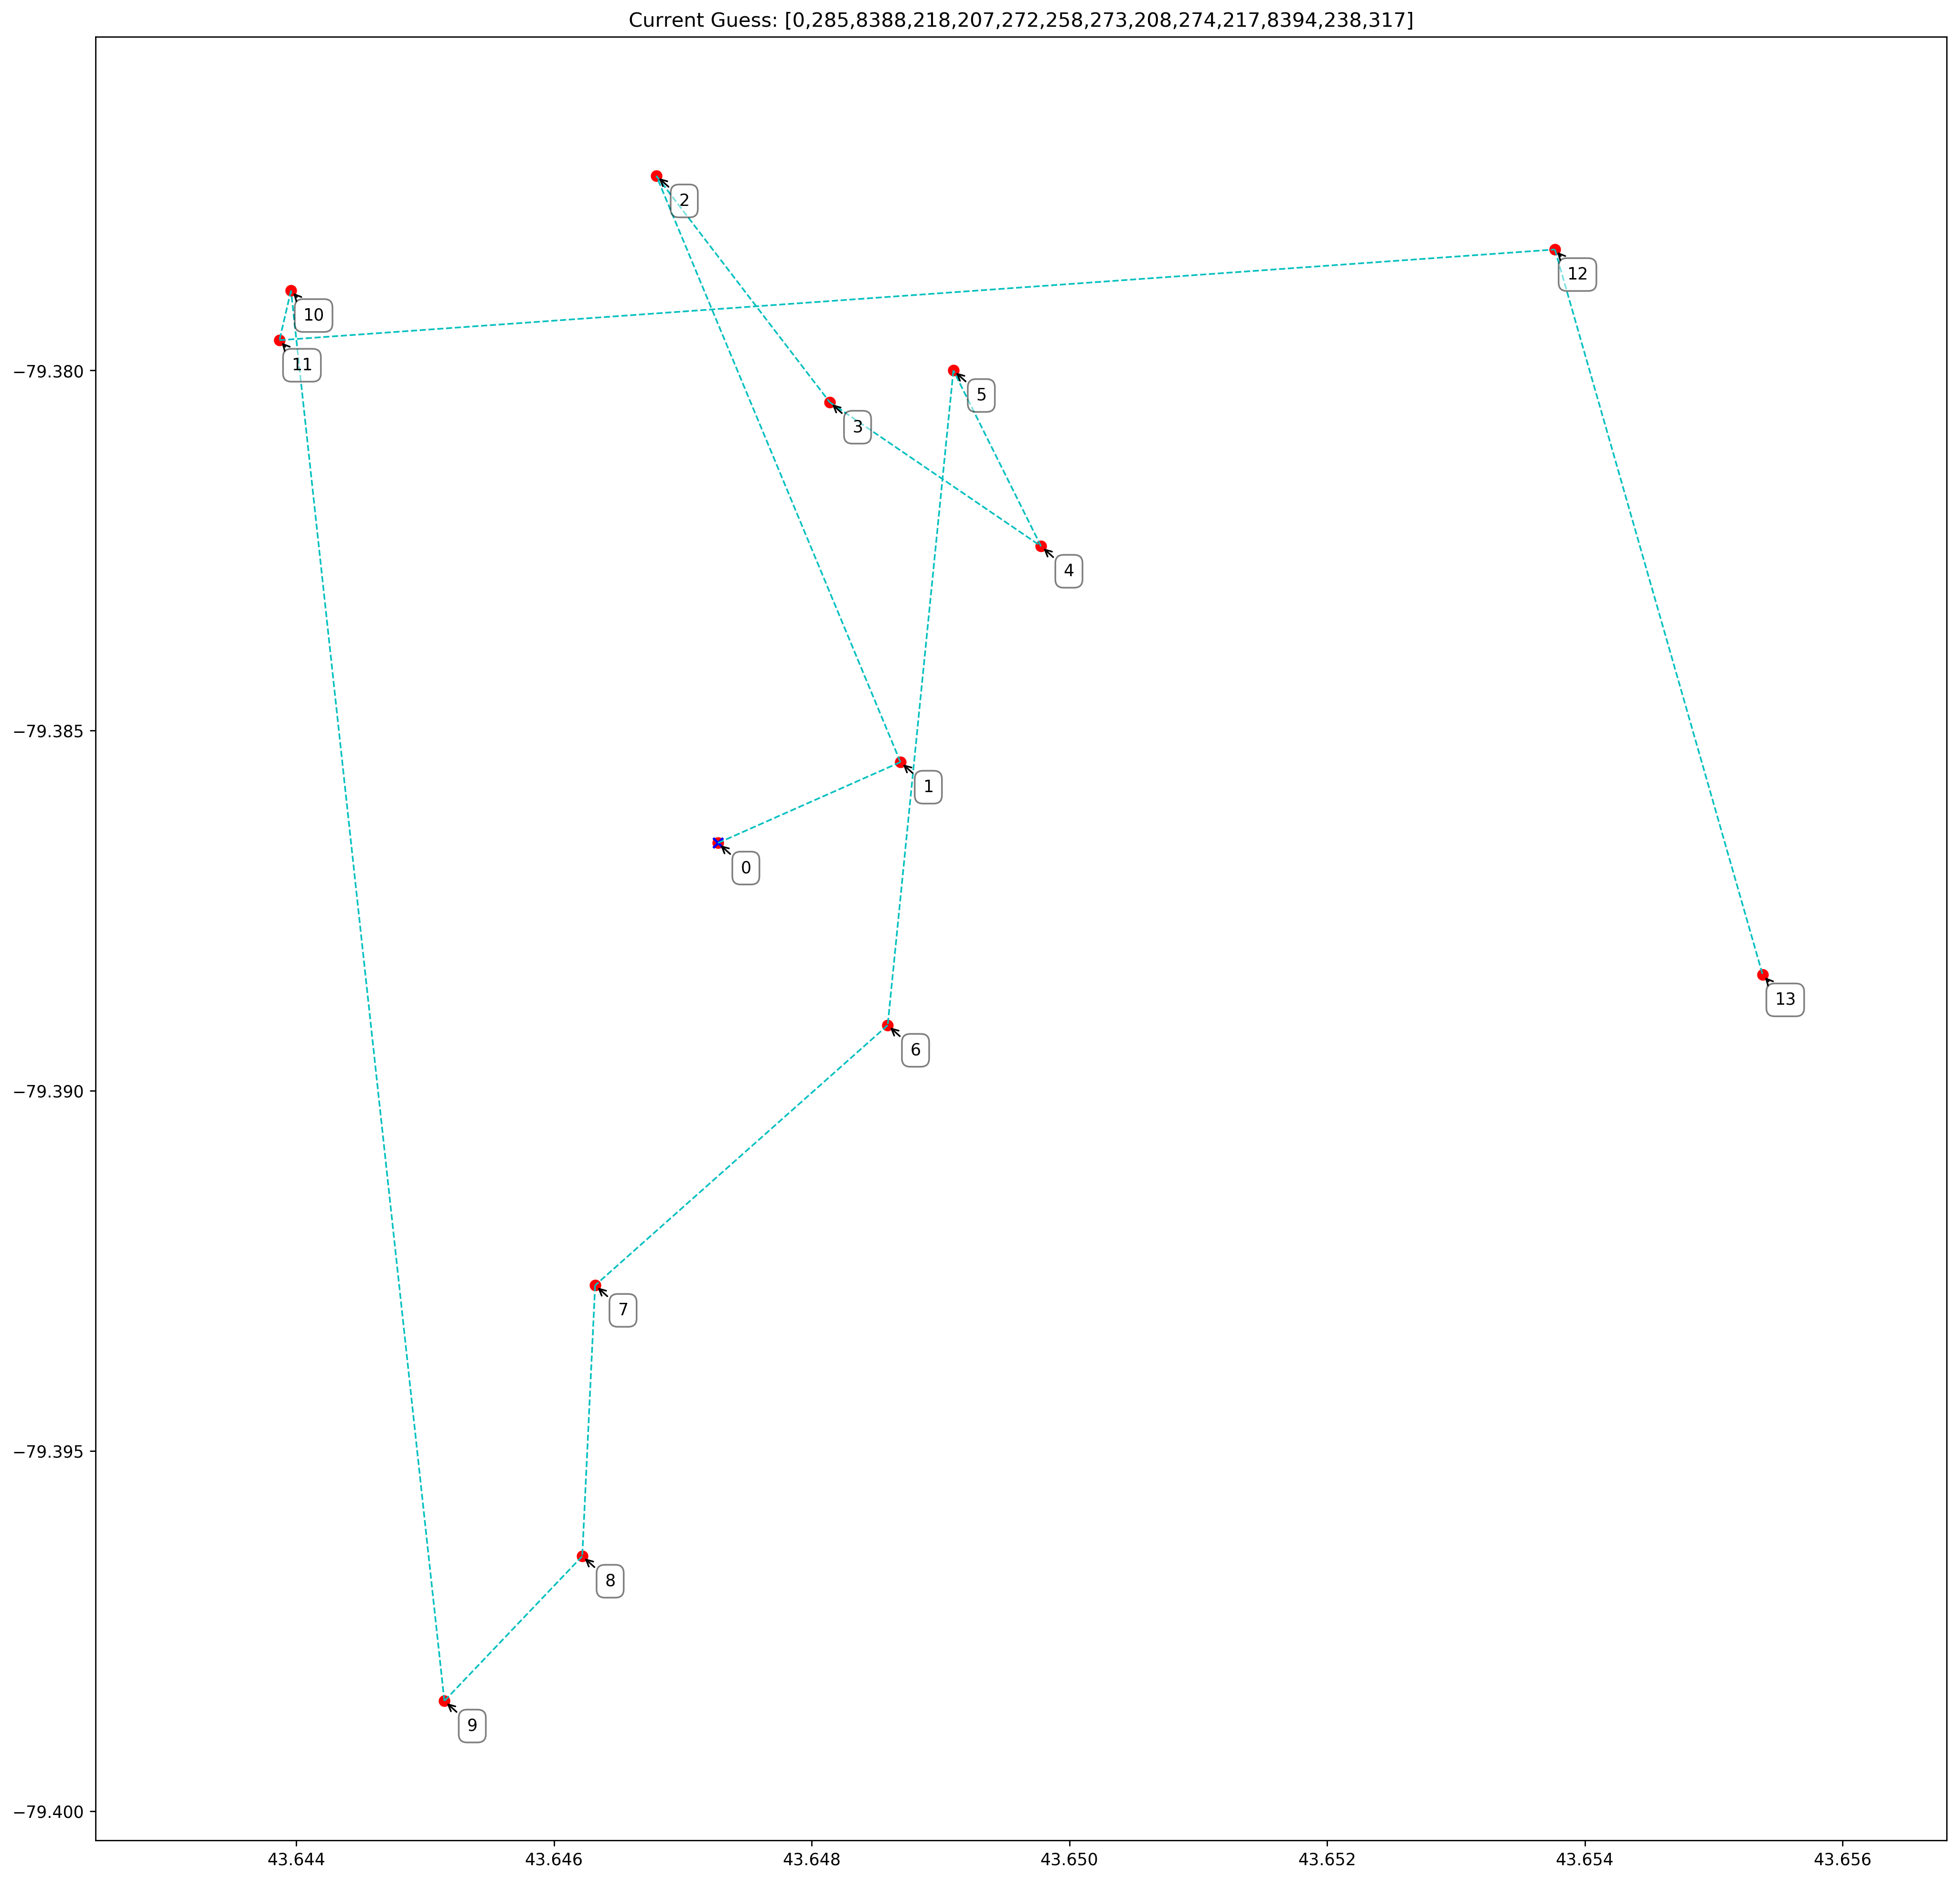

In [317]:
#best_guess
# path = create_guess(list(walk_stops.keys()))
# print(path)
print(best_guess)
plot_guess(walk_stops, best_guess)
# alt_guess=[0, 2945, 3087, 8549, 2985, 2929, 2920, 3077, 3020, 3076, 3078, 2944, 2893, 2896, 2947, 2976, 3021]
# plot_guess(walk_stops,alt_guess)

In [318]:
# add order to df.
print(best_guess[1:])
df_filtered['order'] =0
cnt = 1
for ix in best_guess[1:]:
    print(ix)
   # df_filtered.loc[ix,'order'] = cnt
    index = df_filtered[df_filtered['poi_id'] ==ix].index
    df_filtered.iloc[index,-1]=cnt
#     print( df_filtered.loc[ix,:] )
#     print("\n")
    cnt +=1
df_filtered

[285, 8388, 218, 207, 272, 258, 273, 208, 274, 217, 8394, 238, 317]
285
8388
218
207
272
258
273
208
274
217
8394
238
317


,address,build_decade,build_year,category,cleaned_year,current_use,demolished_year,details,dist_start,external_url,...,latitude,longitude,name,poi_id,poi_type,poi_type_simple,sim_rating,source,style,order
0,University Avenue Financial District Toronto,1930.0,1934,None,1934.0,None,None,None,912.750553,http://www.acotoronto.ca/show_building.php?Bui...,...,43.655380,-79.388390,Adam Beck Memorial,317,Monument,Art,0.5,http://www.acotoronto.ca/,Art deco,13
1,None,NaN,None,Sports,NaN,None,None,"Outside the Hockey Hall of Fame, on the northw...",749.063931,http://torontoplaques.com/Pages/Hockey_Hall_of...,...,43.646795,-79.377299,Hockey Hall of Fame,8388,Plaque,Plaque,0.0,http://torontoplaques.com,None,2
2,None,NaN,None,Sports,NaN,None,None,This Historic Sites and Monuments Board of Can...,678.309342,http://torontoplaques.com/Pages/Toronto_Maple_...,...,43.643870,-79.379580,Toronto Maple Leafs,8394,Plaque,Plaque,0.0,http://torontoplaques.com,None,11
3,234 Bay Street Financial District Toronto,1930.0,1937,None,1937.0,Cultural,None,This building was constructed to house the Tor...,503.065743,http://www.acotoronto.ca/show_building.php?Bui...,...,43.648140,-79.380440,Design Exchange,218,Mid-rise,Building,0.0,http://www.acotoronto.ca/,Art deco,3
4,50 Bay Street Harbourfront Toronto,1990.0,1999,None,1999.0,Sports,None,This bulding incorporates the Art Deco facade ...,720.030462,http://www.acotoronto.ca/show_building.php?Bui...,...,43.643960,-79.378890,Scotiabank Arena,217,High-rise,Building,0.0,http://www.acotoronto.ca/,Art deco,10
5,385 Adelaide Street West Fashion District Toronto,1940.0,1944,None,1944.0,Commercial,None,None,807.260095,http://www.acotoronto.ca/show_building.php?Bui...,...,43.646220,-79.396460,Lorne Building,208,Low-rise,Building,0.0,http://www.acotoronto.ca/,Art deco,8
6,30 Bond Street Downtown East Toronto,1930.0,1937,None,1937.0,Health care,None,None,981.072109,http://www.acotoronto.ca/show_building.php?Bui...,...,43.653768,-79.378321,St. Michael's Hospital,238,Mid-rise,Building,0.0,http://www.acotoronto.ca/,Art deco,12
7,100 Adelaide Street West Financial District To...,1920.0,1928,None,1928.0,Office,None,None,433.671490,http://www.acotoronto.ca/show_building.php?Bui...,...,43.649780,-79.382440,Concourse Building,207,High-rise,Building,0.0,http://www.acotoronto.ca/,Art deco,4
8,388 King Street West Entertainment District To...,1940.0,1941,None,1941.0,Commercial,None,This building was altered in 1986.,506.567601,http://www.acotoronto.ca/show_building.php?Bui...,...,43.646320,-79.392700,388 King Street West,273,Low-rise,Building,0.0,http://www.acotoronto.ca/,Art deco,7
9,26 Duncan Street Entertainment District Toronto,1940.0,1948,None,1948.0,Commercial,None,None,251.147934,http://www.acotoronto.ca/show_building.php?Bui...,...,43.648590,-79.389090,Cundari Building,258,Mid-rise,Building,0.0,http://www.acotoronto.ca/,Art deco,6


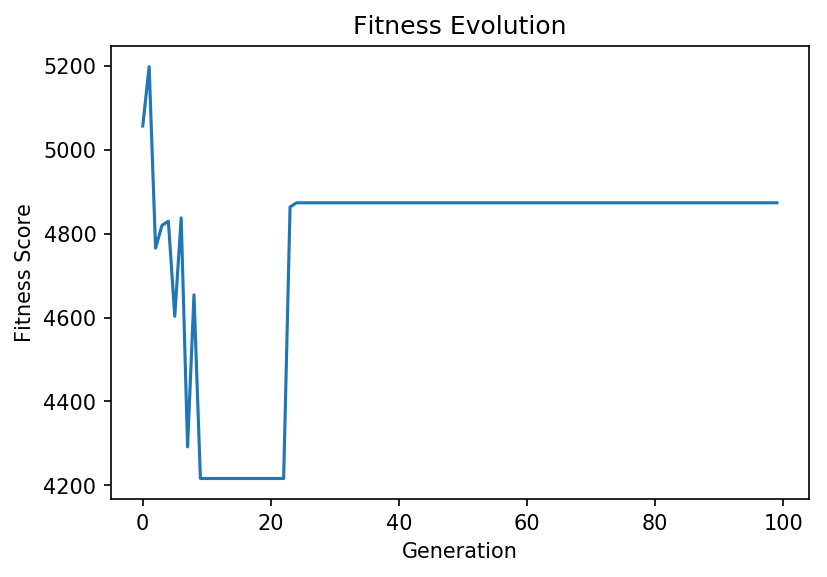

In [319]:
def make_fitness_tracking_plot(fitness_tracking):
    """
    Given a list of fitness scores, plot it versus the generation number
    """
    plt.figure(dpi=150)
    plt.plot(range(len(fitness_tracking)), fitness_tracking)
    plt.ylabel("Fitness Score")
    plt.xlabel("Generation")
    plt.title("Fitness Evolution");

make_fitness_tracking_plot(fitness_tracking)

In [320]:
from folium.features import DivIcon
map_clusters = folium.Map(location=[43.67146, -79.37515], zoom_start=11)
folium.CircleMarker(
    [starting_lat, starting_long],
    radius=5,
    color='red',
     fill=True,
       fill_color='#3186cc',
       fill_opacity=0.7).add_to(map_clusters)



# loop through dataframe
for lat, lng, name, address,order in zip(df_filtered['latitude'], df_filtered['longitude'],  df_filtered['name'],df_filtered['address'], df_filtered['order']):
    label = '{} {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.map.Marker(
    [lat, lng],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
       # html='<b><div style="color:red,font-size: 10pt">{}</div></b>'.format(order),
        html='<b><div style="color:red">{}</div></b>'.format(order),
        )
    ).add_to(map_clusters)
    


map_clusters

# Try with Google OR Tools

In [322]:
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [424]:
# create dictionary of stops with lat/long coords
print(f'starting point ({starting_lat}, {starting_long})')
walk_stops = {}
walk_stops[0] = (starting_lat, starting_long)
for ix,row in df_filtered.iterrows():
    walk_stops[ix+1] = (row['latitude'], row['longitude'])
    #walk_stops[row['poi_id']] = (row['latitude'], row['longitude'])
walk_stops

starting point (43.647273, -79.38656)


{0: (43.647273, -79.38656),
 1: (43.65538, -79.38839),
 2: (43.646795, -79.377299),
 3: (43.64387, -79.37958),
 4: (43.64814, -79.38044),
 5: (43.64396, -79.37889),
 6: (43.64622, -79.39646),
 7: (43.6537678, -79.3783212),
 8: (43.64978, -79.38244),
 9: (43.64632, -79.3927),
 10: (43.64859, -79.38909),
 11: (43.6491, -79.38),
 12: (43.64515, -79.39847),
 13: (43.6486892700195, -79.3854370117188)}

In [466]:
# Distance callback
def create_distance_callback(dist_matrix):
    # Create a callback to calculate distances between cities.

    def distance_callback(from_node, to_node):
        # return int(dist_matrix[from_node][to_node])
        #print(dist_matrix[from_node][to_node])
        return dist_matrix[from_node][to_node]


    return distance_callback

In [461]:
int(dist_matrix[0][5])

0

In [462]:
import googlemaps
import os
#from sqlalchemy import create_engine
from dotenv import load_dotenv, find_dotenv

# USAGE: from create_db import connect_db, create_db_tables,test_database
# db=connect_db() --> establish connection
# db=create_db_tables(db)--> create database tables

load_dotenv(find_dotenv())
# load environment variables
SECRET_KEY = os.getenv("GOOGLE_KEY")
gmaps = googlemaps.Client(key=SECRET_KEY)

In [446]:
len(walk_stops)

14

In [447]:
my_dist_matrix = np.zeros((len(walk_stops), len(walk_stops)))
#dist_matrix = gmaps.distance_matrix(walk_stops.values(),walk_stops.values())
my_dist_matrix[0,0]

0.0

In [448]:
# def create_data():
#     locations = [[288, 149], [288, 129], [270, 133], [256, 141]]
#     return locations

In [449]:
# def create_distance_matrix(locations):
#     # Create the distance matrix.
#     size = len(locations)
#     dist_matrix = {}

#     for from_node in range(size):
#         dist_matrix[from_node] = {}
#         for to_node in range(size):
#             x1 = locations[from_node][0]
#             y1 = locations[from_node][1]
#             x2 = locations[to_node][0]
#             y2 = locations[to_node][1]
#             dist_matrix[from_node][to_node] = 50#euclid_distance(x1, y1, x2, y2)
#     return dist_matrix

In [450]:
# locations = create_data()
# dist_matrix = create_distance_matrix(locations)

In [451]:
# dist_matrix

In [452]:
import math
def euclid_distance(x1, y1, x2, y2):
    # Euclidean distance between points.
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist

In [475]:
def create_distance_matrix(locations):
    # Create the distance matrix.
    size = len(locations)
    dist_matrix = {}

    for from_node in locations.keys():
        dist_matrix[from_node] = {}
        for to_node in locations.keys():
            x1 = locations.get(from_node)[0]
            y1 = locations.get(from_node)[1]
            x2 = locations.get(to_node)[0]
            y2 = locations.get(to_node)[1]
            #print(x1,y1, x2, y2)
           # dist_matrix[from_node][to_node] = euclid_distance(x1, y1, x2, y2)
            dist_matrix[from_node][to_node]  = gmaps.distance_matrix((x1,y1), (x2,y2), mode='walking')["rows"][0]["elements"][0]["distance"]["value"]
    return dist_matrix

In [473]:
dist_matrix=create_distance_matrix(walk_stops)

43.647273 -79.38656 43.647273 -79.38656
43.647273 -79.38656 43.65538 -79.38839
43.647273 -79.38656 43.646795 -79.377299
43.647273 -79.38656 43.64387 -79.37958
43.647273 -79.38656 43.64814 -79.38044
43.647273 -79.38656 43.64396 -79.37889
43.647273 -79.38656 43.64622 -79.39646
43.647273 -79.38656 43.6537678 -79.3783212
43.647273 -79.38656 43.64978 -79.38244
43.647273 -79.38656 43.64632 -79.3927
43.647273 -79.38656 43.64859 -79.38909
43.647273 -79.38656 43.6491 -79.38
43.647273 -79.38656 43.64515 -79.39847
43.647273 -79.38656 43.6486892700195 -79.3854370117188
43.65538 -79.38839 43.647273 -79.38656
43.65538 -79.38839 43.65538 -79.38839
43.65538 -79.38839 43.646795 -79.377299
43.65538 -79.38839 43.64387 -79.37958
43.65538 -79.38839 43.64814 -79.38044
43.65538 -79.38839 43.64396 -79.37889
43.65538 -79.38839 43.64622 -79.39646
43.65538 -79.38839 43.6537678 -79.3783212
43.65538 -79.38839 43.64978 -79.38244
43.65538 -79.38839 43.64632 -79.3927
43.65538 -79.38839 43.64859 -79.38909
43.65538 -79

In [474]:
dist_matrix

{0: {0: 0,
  1: 1054,
  2: 947,
  3: 994,
  4: 580,
  5: 1003,
  6: 946,
  7: 1319,
  8: 590,
  9: 518,
  10: 330,
  11: 696,
  12: 987,
  13: 272},
 1: {0: 1054,
  1: 0,
  2: 1706,
  3: 1753,
  4: 1297,
  5: 1762,
  6: 1653,
  7: 1080,
  8: 1001,
  9: 1459,
  10: 962,
  11: 1325,
  12: 1926,
  13: 782},
 2: {0: 947,
  1: 1706,
  2: 0,
  3: 485,
  4: 421,
  5: 422,
  6: 1871,
  7: 880,
  8: 752,
  9: 1445,
  10: 1259,
  11: 493,
  12: 1913,
  13: 925},
 3: {0: 994,
  1: 1753,
  2: 485,
  3: 0,
  4: 558,
  5: 455,
  6: 1845,
  7: 1365,
  8: 889,
  9: 1408,
  10: 1324,
  11: 775,
  12: 1876,
  13: 972},
 4: {0: 580,
  1: 1297,
  2: 421,
  3: 558,
  4: 0,
  5: 495,
  6: 1504,
  7: 847,
  8: 331,
  9: 1098,
  10: 908,
  11: 216,
  12: 1566,
  13: 558},
 5: {0: 1037,
  1: 1797,
  2: 647,
  3: 763,
  4: 730,
  5: 0,
  6: 1961,
  7: 1505,
  8: 1061,
  9: 1535,
  10: 1349,
  11: 946,
  12: 2003,
  13: 1015},
 6: {0: 946,
  1: 1653,
  2: 1871,
  3: 1850,
  4: 1504,
  5: 1927,
  6: 0,
  7: 1948,

In [456]:
# # Loop through each row in the data frame using pairwise
# from itertools import tee
# #use pairwise function to be used to iterate through two consecutive rows (pairs) in a data frame
# def pairwise(iterable):
#     a, b = tee(iterable)
#     next(b, None)
#     return zip(a, b)

# ct=0
# for (i1, row1), (i2, row2) in pairwise(walk_stops.values()):
#     #for (i1, row1), (i2, row2) in pairwise(df.iterrows()):
# #     print(i1, row1)
# #     print(i2, row1)
# #     #Assign latitude and longitude as origin/departure points
# #     LatOrigin = row1['Latitude']
# #     LongOrigin = row1['Longitude']
#     origins = (i1, row1) #(LatOrigin,LongOrigin)

#     #Assign latitude and longitude from the next row as the destination point
# #     LatDest = row2['Latitude']   # Save value as lat
# #     LongDest = row2['Longitude']  # Save value as lat
#     destination = (i2, row2) #(LatDest,LongDest)
#     print(origins, destination)
    
#     #pass origin and destination variables to distance_matrix function# output in meters
#     result = gmaps.distance_matrix(origins, destination, mode='walking')["rows"][0]["elements"][0]["distance"]["value"]
#     print(result)
#     ct+=1
#     my_dist_matrix[0,ct] = result
    
#     #append result to list
#     #list.append(result)
    

In [477]:
#dist_matrix
#https://developers.google.com/optimization/routing/tsp
tsp_size = len(walk_stops)
num_routes = 1
depot = 0


# # Create routing model.
# if tsp_size > 0:
#     routing = pywrapcp.RoutingModel(tsp_size, num_routes, depot)
#     search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
#     routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
#     print(search_parameters)
#     # Solve the problem.
#     assignment = routing.SolveWithParameters(search_parameters)
#     if assignment:

#         # Solution cost.
#         print ("Total distance: " + str(assignment.ObjectiveValue()) + "\n")
#         # Inspect solution.
#         # Only one route here; otherwise iterate from 0 to routing.vehicles() - 1.
#         route_number = 0
#         node = routing.Start(route_number)
#         start_node = node
#         route = ''

#         while not routing.IsEnd(node):
#             route += str(node) + ' -> '
#             node = assignment.Value(routing.NextVar(node))
#         route += '0'
#         print ("Route:\n\n" + route)
#     else:
#         print ('No solution found.')
# else:
#     print ('Specify an instance greater than 0.')



# Create routing model
if tsp_size > 0:
    routing = pywrapcp.RoutingModel(tsp_size, num_routes, depot)
    search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
    # Create the distance callback.
    dist_callback = create_distance_callback(dist_matrix)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)
    if assignment:
        # Solution distance.
        print ("Total distance: " + str(assignment.ObjectiveValue()) + " miles\n")
        # Display the solution.
        # Only one route here; otherwise iterate from 0 to routing.vehicles() - 1
        route_number = 0
        index = routing.Start(route_number) # Index of the variable for the starting node.
        route = ''
        while not routing.IsEnd(index):
            # Convert variable indices to node indices in the displayed route.
            print(routing.IndexToNode(index))
            route += str(walk_stops[routing.IndexToNode(index)]) + ' -> '
            index = assignment.Value(routing.NextVar(index))
        route += str(walk_stops[routing.IndexToNode(index)])
        print ("Route:\n\n" + route)
    else:
        print( 'No solution found.')
else:
    print ('Specify an instance greater than 0.')

Total distance: 7895 miles

0
9
12
6
10
1
7
11
2
3
5
4
8
13
Route:

(43.647273, -79.38656) -> (43.64632, -79.3927) -> (43.64515, -79.39847) -> (43.64622, -79.39646) -> (43.64859, -79.38909) -> (43.65538, -79.38839) -> (43.6537678, -79.3783212) -> (43.6491, -79.38) -> (43.646795, -79.377299) -> (43.64387, -79.37958) -> (43.64396, -79.37889) -> (43.64814, -79.38044) -> (43.64978, -79.38244) -> (43.6486892700195, -79.3854370117188) -> (43.647273, -79.38656)


In [478]:
route

'(43.647273, -79.38656) -> (43.64632, -79.3927) -> (43.64515, -79.39847) -> (43.64622, -79.39646) -> (43.64859, -79.38909) -> (43.65538, -79.38839) -> (43.6537678, -79.3783212) -> (43.6491, -79.38) -> (43.646795, -79.377299) -> (43.64387, -79.37958) -> (43.64396, -79.37889) -> (43.64814, -79.38044) -> (43.64978, -79.38244) -> (43.6486892700195, -79.3854370117188) -> (43.647273, -79.38656)'

In [483]:
#initialize map with a default lat and long
map_clusters = folium.Map(location=[43.67146, -79.37515], zoom_start=11)
folium.CircleMarker(
    [starting_lat, starting_long],
    radius=5,
    color='red',
     fill=True,
       fill_color='#3186cc',
       fill_opacity=0.7).add_to(map_clusters)


# loop through dataframe
ct=0
for lat, lng in walk_stops.values():
    folium.map.Marker(
    [lat, lng],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
       # html='<b><div style="color:red,font-size: 10pt">{}</div></b>'.format(order),
        html='<b><div style="color:red">{}</div></b>'.format(ct),
        )
    ).add_to(map_clusters)
    ct +=1
    

#0
9
12
6
10
1
7
11
2
3
5
4
8
13

map_clusters

In [325]:

# def main():
#   # Cities
#   city_names = ["New York", "Los Angeles", "Chicago", "Minneapolis", "Denver", "Dallas", "Seattle",
#                 "Boston", "San Francisco", "St. Louis", "Houston", "Phoenix", "Salt Lake City"]
#   # Distance matrix
#   dist_matrix = [
#     [   0, 2451,  713, 1018, 1631, 1374, 2408,  213, 2571,  875, 1420, 2145, 1972], # New York
#     [2451,    0, 1745, 1524,  831, 1240,  959, 2596,  403, 1589, 1374,  357,  579], # Los Angeles
#     [ 713, 1745,    0,  355,  920,  803, 1737,  851, 1858,  262,  940, 1453, 1260], # Chicago
#     [1018, 1524,  355,    0,  700,  862, 1395, 1123, 1584,  466, 1056, 1280,  987], # Minneapolis
#     [1631,  831,  920,  700,    0,  663, 1021, 1769,  949,  796,  879,  586,  371], # Denver
#     [1374, 1240,  803,  862,  663,    0, 1681, 1551, 1765,  547,  225,  887,  999], # Dallas
#     [2408,  959, 1737, 1395, 1021, 1681,    0, 2493,  678, 1724, 1891, 1114,  701], # Seattle
#     [ 213, 2596,  851, 1123, 1769, 1551, 2493,    0, 2699, 1038, 1605, 2300, 2099], # Boston
#     [2571,  403, 1858, 1584,  949, 1765,  678, 2699,    0, 1744, 1645,  653,  600], # San Francisco
#     [ 875, 1589,  262,  466,  796,  547, 1724, 1038, 1744,    0,  679, 1272, 1162], # St. Louis
#     [1420, 1374,  940, 1056,  879,  225, 1891, 1605, 1645,  679,    0, 1017, 1200], # Houston
#     [2145,  357, 1453, 1280,  586,  887, 1114, 2300,  653, 1272, 1017,    0,  504], # Phoenix
#     [1972,  579, 1260,  987,  371,  999,  701, 2099,  600, 1162,  1200,  504,   0]] # Salt Lake City

#   tsp_size = len(city_names)
#   num_routes = 1
#   depot = 0

#   # Create routing model
#   if tsp_size > 0:
#     routing = pywrapcp.RoutingModel(tsp_size, num_routes, depot)
#     search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
#     # Create the distance callback.
#     dist_callback = create_distance_callback(dist_matrix)
#     routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
#     # Solve the problem.
#     assignment = routing.SolveWithParameters(search_parameters)
#     if assignment:
#       # Solution distance.
#       print ("Total distance: " + str(assignment.ObjectiveValue()) + " miles\n")
#       # Display the solution.
#       # Only one route here; otherwise iterate from 0 to routing.vehicles() - 1
#       route_number = 0
#       index = routing.Start(route_number) # Index of the variable for the starting node.
#       route = ''
#       while not routing.IsEnd(index):
#         # Convert variable indices to node indices in the displayed route.
#         route += str(city_names[routing.IndexToNode(index)]) + ' -> '
#         index = assignment.Value(routing.NextVar(index))
#       route += str(city_names[routing.IndexToNode(index)])
#       print ("Route:\n\n" + route)
#     else:
#       print( 'No solution found.')
#   else:
#     print ('Specify an instance greater than 0.')

# if __name__ == '__main__':
#   main()

Total distance: 7293 miles

Route:

New York -> Boston -> Chicago -> Minneapolis -> Denver -> Salt Lake City -> Seattle -> San Francisco -> Los Angeles -> Phoenix -> Houston -> Dallas -> St. Louis -> New York
